# CLASSIFYING AMAZON FOOD REVIEWS USING K-NEAREST NEIGHBORS

In [1]:
# Importing the libraries required for the dataset

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


In [2]:
# At this stage we will be importing the required sqlite dataset

con = sqlite3.connect('database.sqlite')

'''
Our objective is to check whether the review is positive or negative.

The dataset originally consists of reviews from 1 to 5. We will consider reviews which are rated as 4 and 5 to be positive, reviews 
which are rated 1 and 2 to be negative. As, we cannot draw any conclusions from review which is rated 3 star we will eliminate
all the reviews rated 3 star.

'''

# Filtering out the data w/o the 3 star reviews.

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

In [3]:
# Checking whether the data has been filtered properly

filtered_data['Score'].unique()

# We can see that there is no 3 star review in the data

array([5, 1, 4, 2], dtype=int64)

In [4]:
# As we have eliminated the data with 3 start reviews, we will label the remaining data(4 and 5 scores) as positive and negative(1 and 2 scores).

# Creating a function to label the data
def partition(x):
    if x < 3:
        return '0'
    return '1'


# Applying the labels to the data

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [5]:
# Checking the first few rows of the data

filtered_data.head(10)

# We can see that the score has been changed to positive and negative instead of 5,4,1,2

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
# Let us look at the shape of the data

filtered_data.shape

(525814, 10)

In [7]:
# Dropping any duplicates if they are present in the data

duplicates_dropped=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
duplicates_dropped.shape

(364173, 10)

In [8]:
# Eliminating the rows where helpfulness numerator is greator than the helfulness denominator

final=duplicates_dropped[duplicates_dropped.HelpfulnessNumerator<=duplicates_dropped.HelpfulnessDenominator]

In [9]:
# We will need only the review and the score column for the further processing, therefore we will only select the reqd columns

#final_data = final[['Text','Score']]

In [10]:
# Taking a look at the shape of the data

final.shape

(364171, 10)

In [11]:
# We will select only the required columns of which we will filter required reviews and assign them their labels and sort them wrt time

final_data = final[['ProductId','Time','Text','Score']]


In [12]:
# Checking the dimension of the data
final_data.shape


(364171, 4)

In [13]:
# Randomly selecting only 5000 reviews from the final_data

# First we will extract the values from the given dataframe

X=final_data.iloc[:,:].values

# randomly extracting 5000 reviews from the dataset

import random

n = 364171
m = 5000
p = m/n

sampled_data = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_data.append(X[i,:])



In [14]:
# Assigning the extracted data to a dataframe

names = ['ProductId','Time','Text','Score']

sample = pd.DataFrame(sampled_data,columns= names)

In [15]:
# Checking the dimensions of the sampled data

sample.shape

(14999, 4)

In [16]:
# Checking the first few rows of the data

sample.head()

,ProductId,Time,Text,Score
0,B001GVISJM,1318032000,Candy was delivered very fast and was purchase...,1
1,B001EO5QW8,1175212800,Instant oatmeal can become soggy the minute th...,1
2,B001GVISJC,1289260800,Grape gummy bears are hard to find in my area....,1
3,B003ZFRKGO,1325635200,I know the product title says Molecular Gastro...,1
4,B0019CW0HE,1335398400,I have a standard poodle and pomeranian who bo...,1


In [17]:
# Now we will sort the data according to timestamp

sorted_data=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
# Checking if the data has been sorted or not

sorted_data.head(15)

,ProductId,Time,Text,Score
13017,B00005U2FA,1022112000,I'm never dissapointed with the great gadgets ...,1
7058,B00004RYGX,1036022400,Beetlejuice is the story of ghosts (Alec Baldw...,1
1518,B0000A0BS8,1067644800,The grocery store has all kinds of &quot;gourm...,1
5356,B0000D9N59,1068422400,This amazingly flavored cheese was at the top ...,1
6421,B0000DIZ6N,1070236800,There's alot of good tasting gum but this is e...,1
10829,B0000DYZCG,1071187200,I received this as a gift. Great quality and o...,1
7405,B0000DIYKD,1072656000,I recently purchased a bag of Kookaburra Black...,1
7057,B00004RYGX,1079395200,"At the time of its release in 1988, 'Beetlejui...",1
13693,B0001YNGMO,1082592000,I have been taking amazing grass for about a y...,1
11968,B0000DBN2K,1083196800,I have tried many Tazo and this was a similar ...,1


In [19]:
# We can see that the data has been sorted wrt time, now we will only consider the 'Text' and 'Score' columns henceforth

sorted_final = sorted_data[['Text','Score']]


In [20]:
# Checking the first few rows of the data to ensure we have the right data

sorted_final.head()

,Text,Score
13017,I'm never dissapointed with the great gadgets ...,1
7058,Beetlejuice is the story of ghosts (Alec Baldw...,1
1518,The grocery store has all kinds of &quot;gourm...,1
5356,This amazingly flavored cheese was at the top ...,1
6421,There's alot of good tasting gum but this is e...,1


In [21]:
# The next task is to clean the text data so that it can be fed to the model

# Checking if there are unknown elements in the data

# find sentences containing HTML tags

import re

i=0;
for sent in sorted_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   
    
# We can see that the data contains html tags, we will need to remove those

1
Beetlejuice is the story of ghosts (Alec Baldwin and Geena Davis) who can't get along with the family (Jeffrey Jones, Catherine O'Hara, and Winona Ryder) that moves into their house. The ghosts enlist Beetlejuice (Michael Keaton) to help them, and the fun really starts. The movie is directed by Tim Burton. Robert Goulet and Dick Cavett make cameos. The score is by Danny Elfman. This movie has a great cast and a great director. <p>If you're a fan of Burton's other movies, you'll especially like this movie. Like all his movies, it has his distinctive look and feel to it. But anyone can enjoy this far-fetched comedy. Being PG, it should be appropriate for most members of the family. The DVD is lacking some of the special features that I would like to see though - like outtakes, behing-the-scenes, etc...


In [22]:
'''
We will perform the data cleaning steps on the text data.
For that we will import some packages for stopwords removal, word stemmatization and cleaning html and punctuation marks.
'''
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kulkarni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [24]:
# Assigning the cleaned text to the dataframe 'sorted_final'

sorted_final['Cleaned_Text'] = final_string

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Checking the first few rows of the data frame

sorted_final.head()

,Text,Score,Cleaned_Text
13017,I'm never dissapointed with the great gadgets ...,1,b'never dissapoint great gadget compani come b...
7058,Beetlejuice is the story of ghosts (Alec Baldw...,1,b'beetlejuic stori ghost alec baldwin geena da...
1518,The grocery store has all kinds of &quot;gourm...,1,b'groceri store kind coffe laid one tri tast l...
5356,This amazingly flavored cheese was at the top ...,1,b'amaz flavor chees top food triangl throughou...
6421,There's alot of good tasting gum but this is e...,1,b'there alot good tast gum easili one best ext...


# We will do the classification based on various representations of the text data i.e BoW, Tf-Idf, Avg W2Vec, Tf-Idf Weighted W2Vec


# First we will apply our KNN Algorithm to the data using BRUTE FORCE method

# Using the Bag of Words text representation to create our first KNN model

In [26]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [27]:
# Assigning the Bag of Words representatin to the variable 'X'

X = final_counts

In [28]:
# Assigning the 'positive' and 'negative' score to the 'y' variable

y = np.array(sorted_final['Score'])

In [29]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [31]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''


from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

C:\Users\kulkarni\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



The optimal number of neighbors is 5.


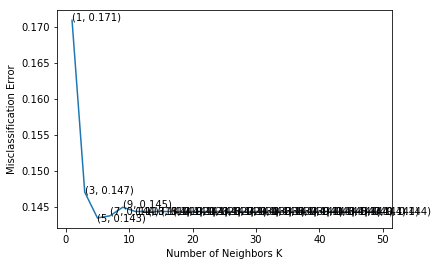

the misclassification error for each k value is :  [0.171 0.147 0.143 0.144 0.145 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [32]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal value for 'k' is 5 based on cross validation scores.

In [33]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy 

from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for the optimal value of k is 84.13%.


The accuracy of the knn classifier for k = 5 is 84.130830%


# Using the 'tf-idf' text representation of the data to create our model using KNN

In [34]:
# In this stage we have initialized the tf-idf vectorizer and applied it to the text data which has been stored in the final_tf_idf vriable

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [35]:
# Assigning the final_tf_idf data to 'X1' variable

X1 = final_tf_idf

In [36]:
# Assinging the score to 'y1' variable

y1 = np.array(sorted_final['Score'])

In [37]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)

In [38]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [39]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'brute')
    scores = cross_val_score(knn, X_train1, y_train1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 9.


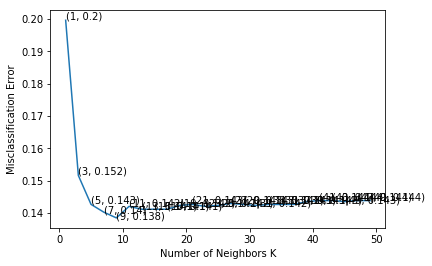

the misclassification error for each k value is :  [0.2   0.152 0.143 0.14  0.138 0.142 0.141 0.141 0.141 0.142 0.143 0.142
 0.142 0.143 0.143 0.142 0.143 0.143 0.143 0.143 0.144 0.144 0.143 0.144
 0.144]


In [40]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of neighbors is 9.

In [41]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy 

from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm= 'brute')

# fitting the model
knn_optimal.fit(X_train1, y_train1)

# predict the response
pred = knn_optimal.predict(X_test1)

# evaluate accuracy
acc = accuracy_score(y_test1, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for optimal number of neighbors is 84.97%


The accuracy of the knn classifier for k = 9 is 84.978801%


# Using the W2Vec representation of the text data to apply the KNN algorithm

In [42]:
# Importing the required models for the project

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\kulkarni\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [43]:
import gensim
i=0
list_of_sent=[]
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [44]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [45]:
words = list(w2v_model.wv.vocab)
print(len(words))

4248


# Creating an Avg W2Vec representation of each review

In [46]:
# Computing the Avg W2Vec representation of each review and storing it in 'sent_vectors' list

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5003
50


In [47]:
# Storing the list in a variable 'X2'

X2 = sent_vectors

In [48]:
# Storing the review score in a 'y2' variable

y2 = sorted_final['Score']

In [49]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [50]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [51]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train2, y_train2, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 19.


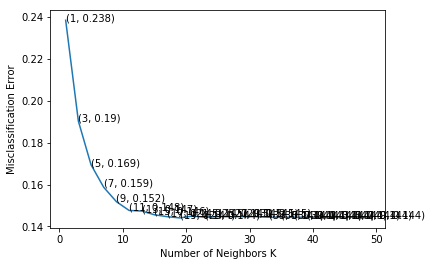

the misclassification error for each k value is :  [0.238 0.19  0.169 0.159 0.152 0.148 0.147 0.146 0.145 0.144 0.145 0.144
 0.145 0.145 0.145 0.145 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [53]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of neighbors is 19 depending upon the cross validation error.

In [54]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy

#from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm= 'brute')

# fitting the model
knn_optimal.fit(X_train2, y_train2)

# predict the response
pred = knn_optimal.predict(X_test2)

# evaluate accuracy
acc = accuracy_score(y_test2, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for optimal number of neighbors is 84.07%


The accuracy of the knn classifier for k = 19 is 84.070260%


# Creating a Tf-Idf weighted W2Vec representation of each review

In [55]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [56]:
# Checking for any 'NaN' values in the data

np.isnan(tfidf_sent_vectors).any()

# We can see that there are na values in the data

True

In [57]:
# We will replace all the 'Nan' values w/ mean of the respective columns


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_tfidf = imp.fit_transform(tfidf_sent_vectors) # Assigning the imputed matrix w/o Nan values to data variable

In [58]:
# Checking if our imputation has succeded

np.isnan(data_tfidf).any()

# We can see that there are no na values any more.

False

In [59]:
# Assigning the 'data_tfidf' matrix to 'X3' variable

X3 = data_tfidf

In [60]:
# Assigning the scores to the 'y3' variable

y3 = sorted_final['Score']

In [61]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=42)

In [62]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [63]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train3, y_train3, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 27.


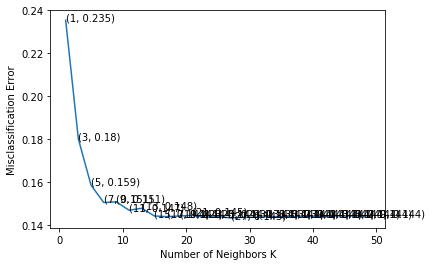

the misclassification error for each k value is :  [0.235 0.18  0.159 0.151 0.151 0.147 0.148 0.144 0.144 0.144 0.145 0.144
 0.144 0.143 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [64]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal value for k is 27, depending upon the cross validation error.

In [65]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy

#from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm= 'brute')

# fitting the model
knn_optimal.fit(X_train3, y_train3)

# predict the response
pred = knn_optimal.predict(X_test3)

# evaluate accuracy
acc = accuracy_score(y_test3, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for optimal number of neighbors is 84.13%.


The accuracy of the knn classifier for k = 27 is 84.130830%


# We have applied the brute force version of the KNN algorithm on various representations of text data the accuracies are as follows:

# Previously we have used the BRUTE FORCE version of KNN, now we will use the KD - TREE version of KNN

# Using the Bag of Words text representation to create our first KNN model

In [66]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [67]:
# Assigning the 'final_counts' matrix to 'X4' variable

X4 = final_counts

In [68]:
# Assigning the matrix to 'y4' variable

y4 = np.array(sorted_final['Score'])

In [69]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.33, random_state=42)

In [70]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [71]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'kd_tree')
    scores = cross_val_score(knn, X_train4, y_train4, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 11.


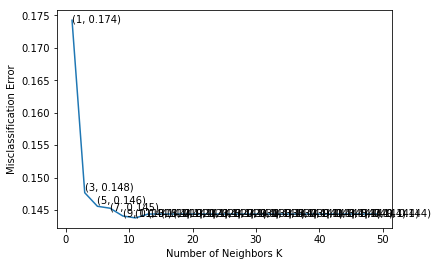

the misclassification error for each k value is :  [0.174 0.148 0.146 0.145 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [72]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of neighbors is 11 depending upon the cross validation error.

In [73]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy

from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train4, y_train4)

# predict the response
pred = knn_optimal.predict(X_test4)

# evaluate accuracy
acc = accuracy_score(y_test4, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for the optimal value of k is 84.49%


The accuracy of the knn classifier for k = 11 is 84.494246%


# Using the 'tf-idf' text representation of the data to create our model using KNN

In [74]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [75]:
# Assigning the 'data_tfidf' matrix to 'X5' variable

X5 = final_tf_idf

In [76]:
# Assigning the scores matrix to 'y5' variable

y5 = np.array(sorted_final['Score'])

In [77]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.33, random_state=42)

In [78]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [79]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'kd_tree')
    scores = cross_val_score(knn, X_train5, y_train5, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 9.


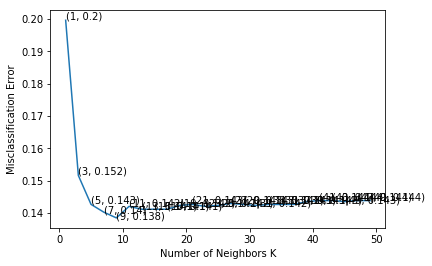

the misclassification error for each k value is :  [0.2   0.152 0.143 0.14  0.138 0.142 0.141 0.141 0.141 0.142 0.143 0.142
 0.142 0.143 0.143 0.142 0.143 0.143 0.143 0.143 0.144 0.144 0.143 0.144
 0.144]


In [80]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of neighbors is 9.

In [81]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy 

from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm= 'kd_tree')

# fitting the model
knn_optimal.fit(X_train5, y_train5)

# predict the response
pred = knn_optimal.predict(X_test5)

# evaluate accuracy
acc = accuracy_score(y_test5, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for optimal number of neighbors is 85.54%


The accuracy of the knn classifier for k = 9 is 84.978801%


# Using the W2Vec representation of the text data to apply the KNN algorithm

In [82]:
# Importing the required models for the project

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [83]:
import gensim
i=0
list_of_sent=[]
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [84]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [85]:
words = list(w2v_model.wv.vocab)
print(len(words))

4248


# Creating an Avg W2Vec representation of each review

In [86]:
# Computing the Avg W2Vec representation of each review and storing it in 'sent_vectors' list
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5003
50


In [87]:
# Storing the list in a variable 'X6'

X6 = sent_vectors

In [88]:
# Storing the review score in a 'y6' variable

y6 = sorted_final['Score']

In [89]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.33, random_state=42)

In [90]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [91]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train6, y_train6, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 23.


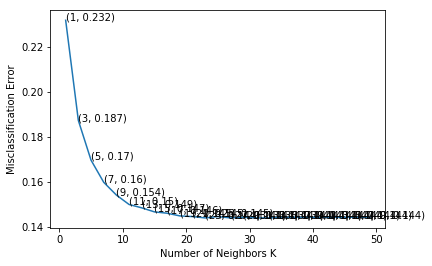

the misclassification error for each k value is :  [0.232 0.187 0.17  0.16  0.154 0.15  0.149 0.147 0.146 0.145 0.145 0.144
 0.145 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [92]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of nearest neighbors is 23.

In [93]:
# ============================== KNN with k = optimal_k ===============================================

# Applying the optimal value of k to our dataset to find the accuracy

#from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm= 'kd_tree')

# fitting the model
knn_optimal.fit(X_train6, y_train6)

# predict the response
pred = knn_optimal.predict(X_test6)

# evaluate accuracy
acc = accuracy_score(y_test6, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# We can see that the accuracy for optimal number of neighbors is 84.25%


The accuracy of the knn classifier for k = 23 is 84.251969%


# Creating a Tf-Idf weighted W2Vec representation of each review

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [95]:
# Checking for any 'NaN' values in the data

np.isnan(tfidf_sent_vectors).any()

# We can see that there are na values in the data

True

In [96]:
# We will replace all the 'Nan' values w/ mean of the respective columns


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_tfidf = imp.fit_transform(tfidf_sent_vectors) # Assigning the imputed matrix w/o Nan values to data variable

In [97]:
# Checking if our imputation has succeded

np.isnan(data_tfidf).any()

# We can see that there are no na values any more.

False

In [98]:
# Assigning the 'data_tfidf' matrix to 'X7' variable

X7 = data_tfidf

In [99]:
# Assigning the scores to the 'y7' variable

y7 = sorted_final['Score']

In [100]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size=0.33, random_state=42)

In [101]:
# Creating a list for k

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [102]:
'''
In this step we will apply 10 fold cross validation to the data and find the optimum value for 'k'
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train7, y_train7, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 29.


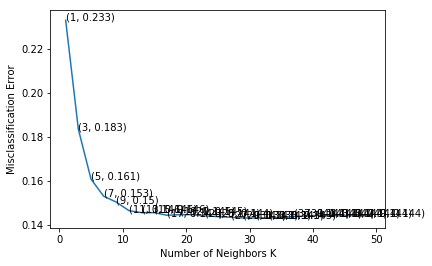

the misclassification error for each k value is :  [0.233 0.183 0.161 0.153 0.15  0.146 0.146 0.146 0.144 0.145 0.145 0.144
 0.144 0.143 0.143 0.143 0.143 0.143 0.144 0.144 0.144 0.144 0.144 0.144
 0.144]


In [103]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# We can see that the optimal number of neighbors is 29.

# We have applied the kd-tree version of the KNN algorithm on various representations of text data the accuracies are as follows:

# From both versions of KNN i.e 'Brute Force' and 'KD-Tree' we can see that we get the maximum accuracy(84.97%) for TF-IDF representation of the text data.